In [65]:
# %pip install -U gymnasium
# %pip install -U gymnasium[classic-control]

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import ipywidgets as widgets
from IPython.display import clear_output
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [106]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

## REINFORCE

In [ ]:
LR = 3e-4
GAMMA = 0.9
MAX_STEPS = 1000
N_HIDDEN = 32
EPS = torch.finfo(torch.float32).eps

In [ ]:
class Policy(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=N_HIDDEN):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)

In [ ]:
policy = Policy(n_in=4, n_out=2).to(device)

In [113]:
def discount_rewards(rewards, gamma):
    '''
    Compute the discounted rewards backwards through time, e.g.
      r0 + gamma * (r1 + gamma * (r2 + gamma * (...)))
      [----------------------------------------------]
         ^         [---------------------------------]
         |           ^           [-------------------]
      discount[0]    |             ^           [-----]
                  discount[1]      |             ^
                                discount[2]      |
                                              discount[n]                                              
    '''
    reward = 0
    discounted_rewards = []
    for r in rewards[::-1]:
        reward = r + gamma * reward
        discounted_rewards.append(reward)
    return torch.tensor(discounted_rewards[::-1]).to(device)

def train(model, epochs=10, lr=LR, gamma=GAMMA, max_steps=MAX_STEPS, log_every=100):
    model = model.to(device)
    model.train()
    opt = optim.Adam(policy.parameters(), lr=lr)
    for epoch in range(epochs):
        rewards, log_probs = [], []
        state, _ = env.reset()
        # forward pass
        for _ in range(MAX_STEPS):
            # this feel bad performance wise, 1 cycle GPU, 1 cycle CPU
            # it's too much context switching
            # how can I benchmark this in a notebook?
            actions = policy(torch.tensor(state).float().to(device))
            m = torch.distributions.Categorical(actions)
            action = m.sample()
            state, reward, done, _, _ = env.step(action.item())
            rewards.append(reward)
            log_probs.append(m.log_prob(action))
            if done:
                break
        # backward pass
        losses = []
        discounted_rewards = discount_rewards(rewards, gamma)
        for log_prob, reward in zip(log_probs, discounted_rewards):
            losses.append(-log_prob * reward)
        loss = torch.stack(losses).sum()
        opt.zero_grad()
        loss.backward()
        opt.step()
        if epoch % log_every == 0:
            print(f'{epoch:5} {loss.item()}')
    model.eval()

train(policy, epochs=1000)

    0 140.72378540039062
  100 389.76593017578125
  200 562.3916015625
  300 1522.986083984375
  400 1174.462890625
  500 1487.4931640625
  600 782.4196166992188
  700 301.91668701171875
  800 1335.84375
  900 1174.96826171875


In [114]:
# save
# ----
# torch.save(policy.state_dict(), 'weights/cartpole-reinforce.pt')

# load
# ----
# m = Policy(n_in=4, n_out=2).to(device)
# m.load_state_dict(torch.load('weights/cartpole-reinforce.pt'))

Episode finished after 413 timesteps


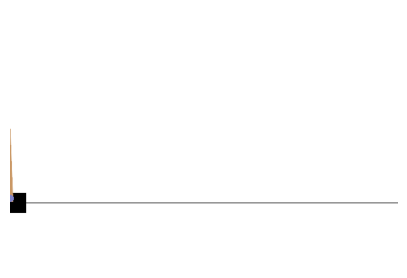

In [112]:
@torch.no_grad()
def show_play(env, policy, max_steps=MAX_STEPS):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.axis('off')
    state, _ = env.reset()
    img = ax.imshow(env.render())
    for t in range(max_steps):
        actions = policy(torch.tensor(state).float().to(device))
        action = actions.argmax()
        state, _, done, _, _ = env.step(action.item())
        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        if done:
            print("Episode finished after {} timesteps".format(t + 1))
            break

show_play(env, policy)

### profiling

In [148]:
def gpu_world(model, arg):
    return model(arg)

def cpu_world_simulate_env(env, action):
    return env.step(action.item())

def cpu_world_sample(rewards, log_probs, env, actions):
    # Categorical seems dog slow
    # --------------------------
    # m = torch.distributions.Categorical(actions)
    # action = m.sample()
    # log_probs.append(m.log_prob(action))

    # multinormal is faster
    # ---------------------
    action = torch.multinomial(actions, 1)
    log_probs.append(torch.log(actions[action]))

    # but they should be equivalent
    # -----------------------------
    # assert m.log_prob(action) - torch.log(actions[action]) < 0.001

    state, reward, done, _, _ = cpu_world_simulate_env(env, action)
    rewards.append(reward)
    return state, done

def cpu_world_backward_pass(rewards, log_probs, gamma):
    losses = []
    discounted_rewards = discount_rewards(rewards, gamma)
    for log_prob, reward in zip(log_probs, discounted_rewards):
        losses.append(-log_prob * reward)
    return losses

def gpu_world_backward_pass(losses, opt):
    loss = torch.stack(losses).to(device).sum()
    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss

def train_for_profiling(model, epochs=100, lr=LR, gamma=GAMMA, max_steps=MAX_STEPS):
    model = model.to(device)
    model.train()
    opt = optim.Adam(policy.parameters(), lr=lr)
    for epoch in range(epochs):
        rewards, log_probs = [], []
        state, _ = env.reset()
        # forward pass
        for _ in range(MAX_STEPS):
            actions = gpu_world(policy, torch.tensor(state).float().to(device))
            state, done = cpu_world_sample(rewards, log_probs, env, actions)
            if done: break
        # backward pass
        losses = cpu_world_backward_pass(rewards, log_probs, gamma)
        loss = gpu_world_backward_pass(losses, opt)
        if epoch % 10 == 0:
            print(f'{epoch:5} {loss.item()}')

In [149]:
import cProfile
import pstats
import io

def profile_train(model):
    pr = cProfile.Profile()
    pr.enable()
    train_for_profiling(model)
    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
    ps.print_stats()
    return s.getvalue()

profile_output = profile_train(policy)
print(profile_output)

    0 460.3211364746094
   10 876.9637451171875
   20 2149.50048828125
   30 1836.753173828125
   40 860.16259765625
   50 827.0250244140625
   60 645.49462890625
   70 943.9664916992188
   80 709.8850708007812
   90 959.7178955078125
         1011506 function calls (923806 primitive calls) in 24.364 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.274    0.274   24.364   24.364 C:\Users\p\AppData\Local\Temp\ipykernel_22632\1234081644.py:41(train_for_profiling)
      100    0.001    0.000    8.839    0.088 C:\Users\p\AppData\Local\Temp\ipykernel_22632\1234081644.py:34(gpu_world_backward_pass)
    17534    0.730    0.000    8.816    0.001 C:\Users\p\AppData\Local\Temp\ipykernel_22632\1234081644.py:7(cpu_world_sample)
      100    0.001    0.000    8.754    0.088 c:\Users\p\Desktop\_ML\huggingface-nlp-course\venv\Lib\site-packages\torch\_tensor.py:428(backward)
      100    0.001    0.000    8.753    0.088 c:\

## A2C

In [ ]:
class Actor(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=10):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)

class Critic(nn.Module):
    def __init__(self, n_in, n_hidden=10):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.f(x)

actor = Actor(n_in=10, n_out=2)
critic = Critic(n_in=10)

In [ ]:
def train(epochs=100, lr=LR):
    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic_opt = optim.Adam(critic.parameters(), lr=lr)

    for epoch in range(epochs):
        state = env.reset()
        done = False

        while not done:
            action_probs = actor(torch.from_numpy(state).float())
            action = torch.multinomial(action_probs, 1).item()

            next_state, reward, done, _ = env.step(action)

            V_current = critic(torch.from_numpy(state).float())
            V_next = critic(torch.from_numpy(next_state).float())

            # Compute advantage and TD-target
            advantage = reward + (1 - int(done)) * V_next - V_current
            td_target = reward + (1 - int(done)) * V_next

            # Update the critic
            critic_loss = advantage.pow(2)
            critic_opt.zero_grad()
            critic_loss.backward()
            critic_opt.step()

            # Update the actor
            actor_loss = -torch.log(action_probs[action]) * advantage.detach()
            actor_opt.zero_grad()
            actor_loss.backward()
            actor_opt.step()

            state = next_state